## Vehicle Detection Project
**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

In [1]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
%matplotlib inline

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

---
### 1. Histogram of Oriented Gradients (HOG)

> Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

First, I defined the HOG function

In [2]:
# vis controls the hog_image for return. feature_vec = True indicates that the returned features will be a 1-d vector
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# It is very importnat that the input domain should be within [0,1] and the output domain is [0,255]
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return img*255

Next, I randomly selected examples of `car` and `notcar`

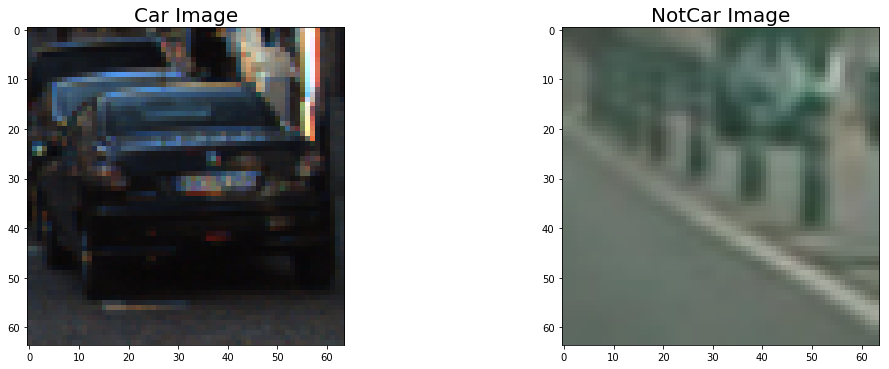

In [3]:
ex_car_path = '../dataset/vehicles/KITTI_extracted_train/1197.png'
ex_notcar_path = '../dataset/non-vehicles/GTI_train/image5.png'
ex_car_img = mpimg.imread(ex_car_path)
ex_notcar_img = mpimg.imread(ex_notcar_path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(ex_car_img)
ax1.set_title('Car Image',fontsize=20)
ax2.imshow(ex_notcar_img)
ax2.set_title('NotCar Image',fontsize=20)

Their corresponding HOG features in each channel of HLS space are showed below

HOG parameters are: `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`

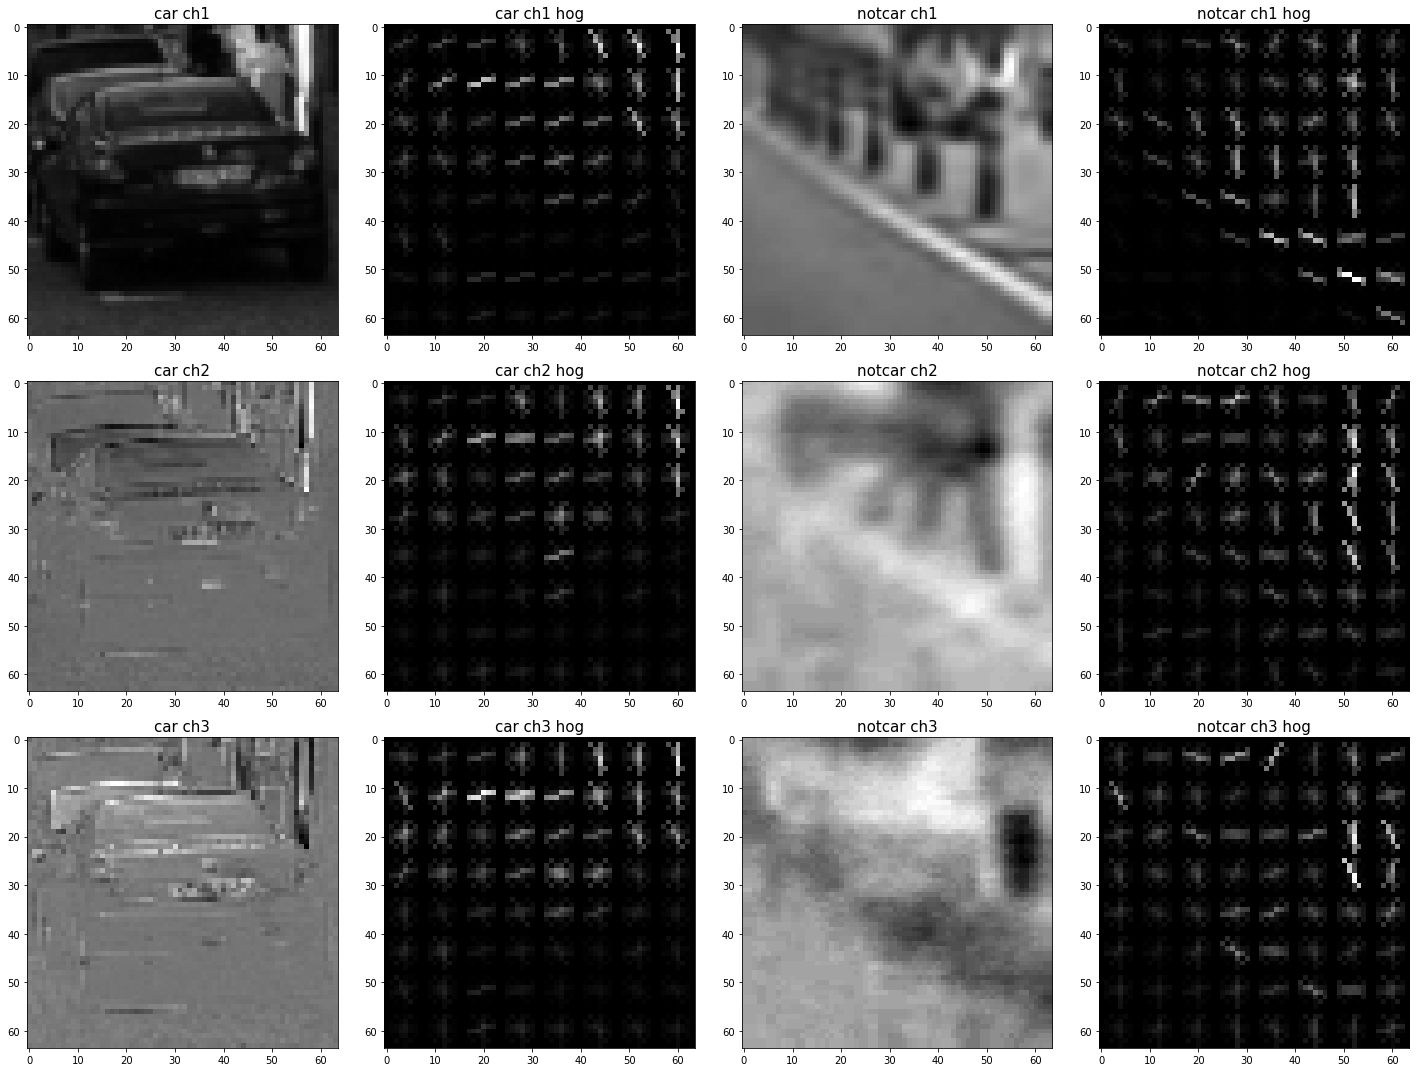

In [4]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

ctrans_ex_car = convert_color(ex_car_img, conv='RGB2YCrCb')
ctrans_ex_notcar = convert_color(ex_notcar_img, conv='RGB2YCrCb')

ch1_car = ctrans_ex_car[:,:,0]
ch2_car = ctrans_ex_car[:,:,1]
ch3_car = ctrans_ex_car[:,:,2]

ch1_notcar = ctrans_ex_notcar[:,:,0]
ch2_notcar = ctrans_ex_notcar[:,:,1]
ch3_notcar = ctrans_ex_notcar[:,:,2]

hog1_fea_car, hog1_img_car = get_hog_features(ch1_car, orient, pix_per_cell, cell_per_block, vis=True)
hog2_fea_car, hog2_img_car = get_hog_features(ch2_car, orient, pix_per_cell, cell_per_block, vis=True)
hog3_fea_car, hog3_img_car = get_hog_features(ch3_car, orient, pix_per_cell, cell_per_block, vis=True)

hog1_fea_notcar, hog1_img_notcar = get_hog_features(ch1_notcar, orient, pix_per_cell, cell_per_block, vis=True)
hog2_fea_notcar, hog2_img_notcar = get_hog_features(ch2_notcar, orient, pix_per_cell, cell_per_block, vis=True)
hog3_fea_notcar, hog3_img_notcar = get_hog_features(ch3_notcar, orient, pix_per_cell, cell_per_block, vis=True)

plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(ch1_car, cmap='gray')
plt.title('car ch1',fontsize=15)
plt.subplot(3,4,2)
plt.imshow(hog1_img_car, cmap='gray')
plt.title('car ch1 hog',fontsize=15)

plt.subplot(3,4,3)
plt.imshow(ch1_notcar, cmap='gray')
plt.title('notcar ch1',fontsize=15)
plt.subplot(3,4,4)
plt.imshow(hog1_img_notcar, cmap='gray')
plt.title('notcar ch1 hog',fontsize=15)

plt.subplot(3,4,5)
plt.imshow(ch2_car, cmap='gray')
plt.title('car ch2',fontsize=15)
plt.subplot(3,4,6)
plt.imshow(hog2_img_car, cmap='gray')
plt.title('car ch2 hog',fontsize=15)

plt.subplot(3,4,7)
plt.imshow(ch2_notcar, cmap='gray')
plt.title('notcar ch2',fontsize=15)
plt.subplot(3,4,8)
plt.imshow(hog2_img_notcar, cmap='gray')
plt.title('notcar ch2 hog',fontsize=15)

plt.subplot(3,4,9)
plt.imshow(ch3_car, cmap='gray')
plt.title('car ch3',fontsize=15)
plt.subplot(3,4,10)
plt.imshow(hog3_img_car, cmap='gray')
plt.title('car ch3 hog',fontsize=15)

plt.subplot(3,4,11)
plt.imshow(ch3_notcar, cmap='gray')
plt.title('notcar ch3',fontsize=15)
plt.subplot(3,4,12)
plt.imshow(hog3_img_notcar, cmap='gray')
plt.title('notcar ch3 hog',fontsize=15)

plt.tight_layout()
plt.savefig('./output_images/HOG_with_YCrCb.jpg')

In order to get a good enough setting for those parameters (`orientations`, `pixels_per_cell` and `cells_per_block`), I applied a **grid searching method** with a linear SVM on a **small subset** of training data. Grid searching space is defined as follows (24 combinations):
```python
orient_set = range(9,19,3)
pix_per_cell_set = [4,8,16]
cell_per_block_set = [1,2]
```

In [5]:
# load a subset of training data and do HOG feature extractions
car_train_dir=['GTI_Far_train','GTI_Left_train','GTI_MiddleClose_train','GTI_Right_train','KITTI_extracted_train']
car_images=[]
car_images_test=[]
for tdir in car_train_dir:
    all_pathes = glob.glob('../dataset/vehicles/'+tdir+'/*.png')
    all_num = len(all_pathes)
    sep_idx = all_num//4
    pathes = all_pathes[sep_idx::4]
    #print('Having {} train images in {}'.format(len(pathes),tdir))
    car_images.extend(pathes)
    pathes = all_pathes[:sep_idx:4]
    #print('Having {} test images in {}'.format(len(pathes),tdir))
    car_images_test.extend(pathes)
print('Total car train images {}'.format(len(car_images)))
print('Total car test images {}'.format(len(car_images_test)))

notcar_train_dir=['Extras_train','GTI_train']
notcar_images=[]
notcar_images_test=[]
for tdir in notcar_train_dir:
    all_pathes = glob.glob('../dataset/non-vehicles/'+tdir+'/*.png')
    all_num = len(all_pathes)
    sep_idx = all_num//4
    pathes = all_pathes[sep_idx::4]
    #print('Having {} train images in {}'.format(len(pathes),tdir))
    notcar_images.extend(pathes)
    pathes = all_pathes[:sep_idx:4]
    #print('Having {} test images in {}'.format(len(pathes),tdir))
    notcar_images_test.extend(pathes)
print('Total not car train images {}'.format(len(notcar_images)))
print('Total not car test images {}'.format(len(notcar_images_test)))
train_num = len(car_images) + len(notcar_images)
test_num = len(car_images_test) + len(notcar_images_test)

Total car train images 1321
Total car test images 442
Total not car train images 1349
Total not car test images 450


In [6]:
all_images = [*car_images,*notcar_images,*car_images_test,*notcar_images_test]

# do feature extraction according to each grid search settings
orient_set = range(9,19,3)
pix_per_cell_set = [4,8,16]
cell_per_block_set = [1,2]

num_combinations = len(orient_set)*len(pix_per_cell_set)*len(cell_per_block_set)

if os.path.exists('./grid_search_results.p'):
    print("Already grid searched")
    isSearched = True
    inside_acc, outside_acc = pickle.load( open( './grid_search_results.p', "rb" ) )
else:
    inside_acc = np.zeros(num_combinations)
    outside_acc = np.zeros(num_combinations)
    isSearched = False
    
count = -1
for orient in orient_set:
    for pix_per_cell in pix_per_cell_set:
        for cell_per_block in cell_per_block_set:
            count+=1
            if not isSearched:
                # do feature extractions
                X = []
                for path in all_images:
                    img = mpimg.imread(path)
                    ctrans = convert_color(img, conv='RGB2YCrCb')
                    hog1_fea = get_hog_features(ctrans[:,:,0], orient, pix_per_cell, cell_per_block)
                    hog2_fea = get_hog_features(ctrans[:,:,1], orient, pix_per_cell, cell_per_block)
                    hog3_fea = get_hog_features(ctrans[:,:,2], orient, pix_per_cell, cell_per_block)
                    X.append(np.concatenate((hog1_fea,hog2_fea,hog3_fea)))
                X = np.array(X).reshape(len(all_images),-1).astype(np.float64)
                X_scaler = StandardScaler().fit(X)
                # Apply the scaler to X
                scaled_X = X_scaler.transform(X)
                scaled_X_train = scaled_X[:train_num,:]
                scaled_X_test = scaled_X[train_num:,:]
                y_train= np.hstack((np.ones(len(car_images)), np.zeros(len(notcar_images))))
                y_test= np.hstack((np.ones(len(car_images_test)), np.zeros(len(notcar_images_test))))

                # Use a linear SVC 
                svc = LinearSVC()
                svc.fit(scaled_X_train, y_train)
                # Check the score of the SVC
                predict_y_inside = svc.predict(scaled_X_train)
                inside_acc[count] = len(np.where((predict_y_inside==y_train)==True)[0])/train_num
                predict_y_outside = svc.predict(scaled_X_test)
                outside_acc[count] = len(np.where((predict_y_outside==y_test)==True)[0])/test_num
            print('{}/{}. outside-acc={}, orient={}, pix_per_cell={}, cell_per_block={}'\
                  .format(count,num_combinations,outside_acc[count],orient,pix_per_cell,cell_per_block))
pickle.dump( (inside_acc, outside_acc), open( "./grid_search_results.p", "wb" ) )

Already grid searched
0/24. outside-acc=0.968609865470852, orient=9, pix_per_cell=4, cell_per_block=1
1/24. outside-acc=0.976457399103139, orient=9, pix_per_cell=4, cell_per_block=2
2/24. outside-acc=0.9551569506726457, orient=9, pix_per_cell=8, cell_per_block=1
3/24. outside-acc=0.9652466367713004, orient=9, pix_per_cell=8, cell_per_block=2
4/24. outside-acc=0.9439461883408071, orient=9, pix_per_cell=16, cell_per_block=1
5/24. outside-acc=0.9495515695067265, orient=9, pix_per_cell=16, cell_per_block=2
6/24. outside-acc=0.9663677130044843, orient=12, pix_per_cell=4, cell_per_block=1
7/24. outside-acc=0.976457399103139, orient=12, pix_per_cell=4, cell_per_block=2
8/24. outside-acc=0.9573991031390134, orient=12, pix_per_cell=8, cell_per_block=1
9/24. outside-acc=0.9652466367713004, orient=12, pix_per_cell=8, cell_per_block=2
10/24. outside-acc=0.9473094170403588, orient=12, pix_per_cell=16, cell_per_block=1
11/24. outside-acc=0.9585201793721974, orient=12, pix_per_cell=16, cell_per_block

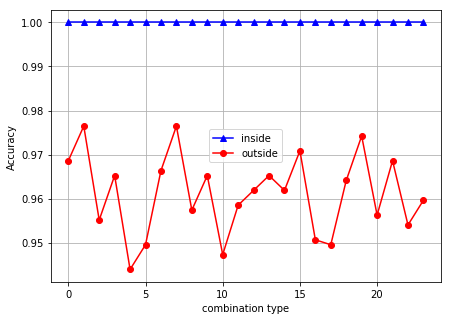

In [7]:
plt.figure(figsize=(7,5))
plt.plot(range(num_combinations), inside_acc, 'b-^', range(num_combinations), outside_acc, 'ro-')
#plt.ylim(0.5,1)
plt.ylabel('Accuracy')
plt.xlabel('combination type')
plt.legend(['inside','outside'],loc='center')
plt.grid()
plt.savefig('./output_images/grid_search.jpg')

The purpose of this stage is not finding the optimal, but rather, a good enough setting. So I choose **`orient=15, pix_per_cell=8, cell_per_block=2, cspace='RGB2YCrCb'`**

In [8]:
# Selected HOG settings
orient = 15
pix_per_cell = 8
cell_per_block = 2
cspace = 'RGB2YCrCb'

---
### 2. Train Classifier

> Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trianed a Linear SVM model with HOG + color_hist + bin_spatial features. First I defined color_hist and bin_spatial function

In [9]:
# Selected bin_spatial setting
spatial_size = (32, 32)
# Selected color_hist setting
hist_bins = 32

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Before training the classifier, dataset should be processed first.
Since the `vehicles/GTI*/*.png`  contains **time-series data**, I **manually selected** images to avoid train and test sets having identical images. In addition, **20%** images in each training folder are treated as test images. The same partition method applied to non-vehicles images too.

Next, I do feature extraction for `train` and `test` sets.

In [11]:
# load a subset of training data and do HOG feature extractions
car_dir=['GTI_Far','GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']
car_images_train=[]
car_images_test=[]
for tdir in car_dir:
    train_pathes = glob.glob('../dataset/vehicles/'+tdir+'_train/*.png')
    test_pathes = glob.glob('../dataset/vehicles/'+tdir+'_test/*.png')
    car_images_train.extend(train_pathes)
    car_images_test.extend(test_pathes)
print('Total car train images {}'.format(len(car_images_train)))
print('Total car test images {}'.format(len(car_images_test)))

notcar_dir=['Extras','GTI']
notcar_images_train=[]
notcar_images_test=[]
for tdir in notcar_dir:
    train_pathes = glob.glob('../dataset/non-vehicles/'+tdir+'_train/*.png')
    test_pathes = glob.glob('../dataset/non-vehicles/'+tdir+'_test/*.png')
    notcar_images_train.extend(train_pathes)
    notcar_images_test.extend(test_pathes)
print('Total not car train images {}'.format(len(notcar_images_train)))
print('Total not car test images {}'.format(len(notcar_images_test)))

Total car train images 7036
Total car test images 1756
Total not car train images 7188
Total not car test images 1780


Definition of Feature Extraction.

>This function is only for training SVM, not very efficient. The final feature extraction should reuse the HOG features for every sliding window that **do HOG once for an image**.

In [12]:
# suppose reading images with scale 0~1
def feature_extraction(img, orient=15, pix_per_cell=8, cell_per_block=2, cspace='RGB2YCrCb'):
    # HOG using cspace
    ctrans = convert_color(img, conv=cspace) # cv2.cvtColor will scale the images to 0~255
    hog1_fea = get_hog_features(ctrans[:,:,0], orient, pix_per_cell, cell_per_block)
    hog2_fea = get_hog_features(ctrans[:,:,1], orient, pix_per_cell, cell_per_block)
    hog3_fea = get_hog_features(ctrans[:,:,2], orient, pix_per_cell, cell_per_block)
    # bin_spatial and color_hist
    bin_spatial_fea, color_hist_fea = bin_spatial(ctrans, size=spatial_size), color_hist(ctrans, nbins=hist_bins)
    return np.concatenate((hog1_fea,hog2_fea,hog3_fea,bin_spatial_fea, color_hist_fea)).astype(np.float64)

In [13]:
all_images = [*car_images_train,*notcar_images_train,*car_images_test,*notcar_images_test]
train_car_num = len(car_images_train)
train_notcar_num = len(notcar_images_train)
test_car_num = len(car_images_test)
test_notcar_num = len(notcar_images_test)
train_num = train_car_num + train_notcar_num
test_num = test_car_num + test_notcar_num
if os.path.exists('./data.p'):
    print("Already feature extracted. Load scaled_X_train, y_train, scaled_X_test, y_test, X_scaler")
    scaled_X_train,y_train,scaled_X_test,y_test,X_scaler = pickle.load( open( './data.p', "rb" ) )
else:
    # Extract all features
    X = []
    for path in all_images:
        img = mpimg.imread(path)
        fea = feature_extraction(img,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,cspace=cspace)
        X.append(fea)
    X = np.array(X).reshape(len(all_images),-1)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    scaled_X_train = scaled_X[:train_num,:]
    scaled_X_test = scaled_X[train_num:,:]
    y_train= np.hstack((np.ones(train_car_num), np.zeros(train_notcar_num)))
    y_test= np.hstack((np.ones(test_car_num), np.zeros(test_notcar_num)))
    data=(scaled_X_train,y_train,scaled_X_test,y_test,X_scaler)
    pickle.dump( data, open( "./data.p", "wb" ) )

Already feature extracted. Load scaled_X_train, y_train, scaled_X_test, y_test, X_scaler


Then I train a Linear SVM classifier

In [14]:
# Use a linear SVC 
if os.path.exists('./svc.p'):
    print("Already trained SVC. Load SVC.")
    svc = pickle.load( open( './svc.p', "rb" ) )
else:
    svc = LinearSVC()
    svc.fit(scaled_X_train, y_train)
    pickle.dump( svc, open( "./svc.p", "wb" ) )
# Check the score of the SVC
predict_y_inside = svc.predict(scaled_X_train)
inside_acc = len(np.where((predict_y_inside==y_train)==True)[0])/train_num
predict_y_outside = svc.predict(scaled_X_test)
outside_acc = len(np.where((predict_y_outside==y_test)==True)[0])/test_num
print('inside-acc={}, outside-acc={}'.format(inside_acc,outside_acc))

Already trained SVC. Load SVC.
inside-acc=1.0, outside-acc=0.9802036199095022


---
### 3. Sliding Window Search

> Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

The course provided a very useful code snippet that can extract HOG features once no matter how much windows are. So I reuse it as the feature extraction function!
I used two types of scales, 1.5 and 1.2, which deal with large and small window respectively (car with near and far positions from camera). Also, I found that the overlaping of cells_per_step = 1 (more dense windows) has better results in my implementation.

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,\
              orient, pix_per_cell, cell_per_block, cspace, spatial_size, hist_bins):
    
    bbox_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((hog_features,spatial_features, hist_features)).astype(np.float64))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #((x1, y1), (x2, y2))
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list

Before going through, it is worth checking the image values. Since feature extraction pipeline processed `.png` files with `mpimg.imread`, it reads images with values [0,1].

However, mpimg.imread reads the .jpg file with values within [0,255]. So it is necessary to divide 255 before calling the feature extraction pipeline while reading .jpg images with mpimg.imread.

> **Make sure your images are scaled correctly**

>The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

>To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if you are testing your pipeline on .jpg images remember to scale them accordingly. And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() you'll get back an image scaled from 0 to 255. So just be sure to be consistent between your training data features and inference features!

---
### 4. Showing Examples

> Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

The followings are some examples. As you can see in the example 2, there exists a **false accept**. This will be filtered out in the **post-processing** part.

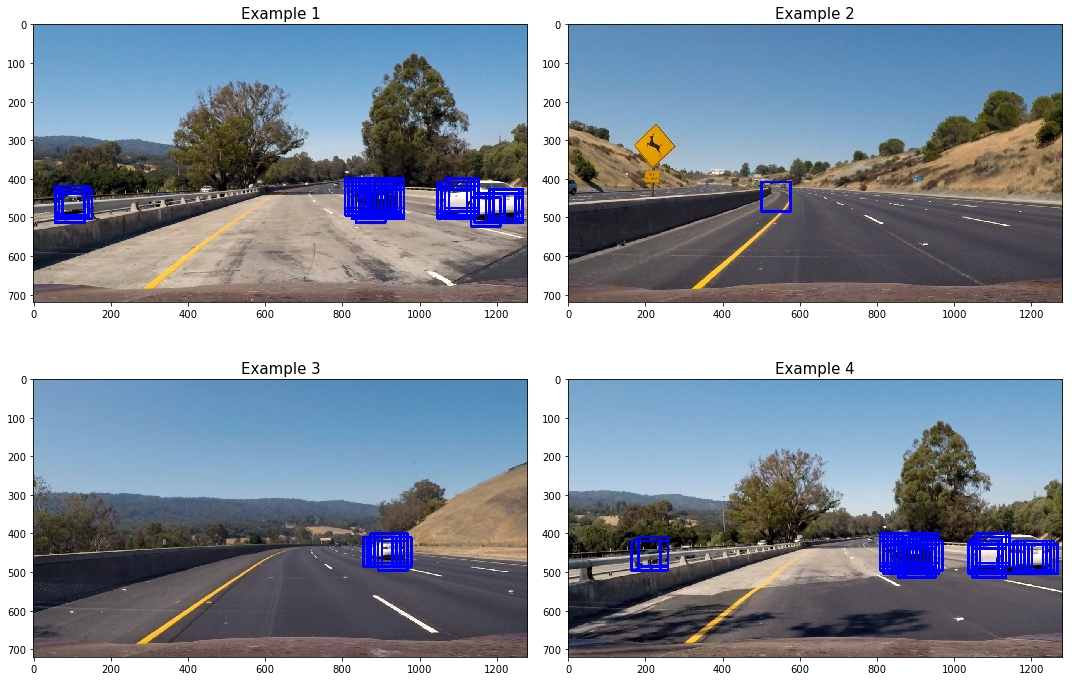

In [16]:
ystart = 400
ystop = 656
scale = 1.2
plt.figure(figsize=(15,10))
for i in range(4):
    img = mpimg.imread('./test_images/test'+str(i+1)+'.jpg')
    out_img, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, cspace, spatial_size, hist_bins)
    plt.subplot(2,2,i+1)
    plt.imshow(out_img)
    plt.title('Example {}'.format(i+1),fontsize=15)
plt.tight_layout()
plt.savefig('./output_images/example_before_post_processing.jpg')

---
### 5. Video Implementation

> Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here is the [link](https://youtu.be/f4AJoeI5_3c) for the final results (combined with post-processing as described below)

In [17]:
def process_image(img):
    out_img, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler,\
                        orient, pix_per_cell, cell_per_block, cspace, spatial_size, hist_bins)
    return out_img

clip_output = './test_video_heat.mp4'
clip1 = VideoFileClip('./test_video.mp4')
clip = clip1.fl_image(process_image) #NOTE: this function expects color images
clip.write_videofile(clip_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

[MoviePy] >>>> Building video ./test_video_heat.mp4
[MoviePy] Writing video ./test_video_heat.mp4


 97%|█████████▋| 38/39 [01:18<00:02,  2.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_heat.mp4 



---
### 6. Further Post-processing

> Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

A heat-map to further filtered out some false positives. Moreover, I used a buffer to keep the 6 consecutive frames of heat-maps, and then accumulated those heat-maps in buffer. The accumulated heat-map then thresholded and produced the final results.

In [31]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # ((x1, y1), (x2, y2))
        box_w = bbox[1][0]-bbox[0][0]
        box_h = bbox[1][1]-bbox[0][1]
        if (1/6)<(box_w/box_h)<6 and box_w>10 and box_h>10:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [33]:
from scipy.ndimage.measurements import label

heat_buff = []
heat_global = np.zeros((720,1280)).astype(np.float)
buff_size = 6
def process_image_post_processing(img):
    global heat_buff
    global heat_global
    
    ystart = 400
    ystop = 656
    scale_large = 1.5
    scale_small = 1.2
    
    _, bbox_list_large = find_cars(img, ystart, ystop, scale_large, svc, X_scaler,\
                        orient, pix_per_cell, cell_per_block, cspace, spatial_size, hist_bins)
    _, bbox_list_small = find_cars(img, ystart, ystop, scale_small, svc, X_scaler,\
                        orient, pix_per_cell, cell_per_block, cspace, spatial_size, hist_bins)
    bbox_list = [*bbox_list_large, *bbox_list_small]
    #print("len(bbox_list_large)={}; len(bbox_list_small)={}; len(bbox_list)={}".format(len(bbox_list_large),len(bbox_list_small),len(bbox_list)))
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    if (len(heat_buff)==buff_size):
        heat_global -= heat_buff[0]
        heat_buff.pop(0)
         
    heat_buff.append(heat)
    heat_global += heat
        
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_global,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

clip_output = './project_video_heat.mp4'
clip1 = VideoFileClip('./project_video.mp4')

#clip_output = './test_video_try.mp4'
#clip1 = VideoFileClip('./test_video.mp4')

clip = clip1.fl_image(process_image_post_processing) #NOTE: this function expects color images
clip.write_videofile(clip_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

[MoviePy] >>>> Building video ./project_video_heat.mp4
[MoviePy] Writing video ./project_video_heat.mp4


100%|█████████▉| 1260/1261 [1:06:35<00:03,  3.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_heat.mp4 



---
### 7. Discussion

> Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

